# CosmoRate scripts notebook

**LoCPb Project 2021 - CosmoRate.**

FPGheArt - Lorenzo Buriola, Filippo Conforto, Lorenzo Domenichetti

Supervisor - Prof. Michela Mapelli, Filippo Santoloquido (PhD).

### Functions and imports

In [3]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.odr import *
import astropy.units as unit
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.cosmology import z_at_value
from matplotlib.transforms import offset_copy
from astropy.cosmology import Planck15 as Planck
from sklearn.linear_model import LinearRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
#Some useful functions

def load_astro(path = "./", LBT = True ):
    '''
    Loading function for datasets with a lookback time calculation option.
    
    ---Parameters:
    
    path: path of the file to load.
    
    LBT: boolean indicating if the Lookbacktime calculation is needed.
    
    '''
    #Reading the choosen dataset 
    data = pd.read_csv(path, delimiter = " ", skiprows=[0], header = None)
    
    if(LBT):
        #Calculating Lookback time if not already present
        data["LBtime"] = Planck.lookback_time(data[0]) 

    return data

def load_mass(path = r'A10/output/BBH/', binary = "BBH*"):
    '''
    The function is used to load all the binary catalogues and merge them in a 
    single dataset 
    
    ---Parameters:
    
    path: path of the directory containing files
    
    binary: parameter used to load only files regarding choosen 
    binaries 
    
    '''
    all_files = glob.glob(path + binary)

    frame = pd.concat([pd.read_csv(filename, index_col=None, header=None,  skiprows=[0], delimiter = " ") for filename in all_files], axis=0, ignore_index=True)
    frame.columns = ["m1","m2","z_merg","z_form","time_delay","Z_prog"]
    
    return frame

    
def star_fr(z):
    '''
    Star formation rate calculator.
    
    
    ---Parameters:
    
    z: redshift
    '''
    return 0.01*(1+z)**2.6/(1+((1+z)/3.2)**6.2)


def grid_plot(dfs,   q1 = 0.25, q2 = 0.75, y_lo = [10,10,10], y_hi = [2000,2000,2000], LBT = True
              , t_list = ["BBH","BNS","BHNS"], m_list = ["A1","A5","A10"], err = True, fit = False
              , fit_err = False, up_to = 1.5, save = ""):
    '''
    Function producing grid plots for a given set of dataframes
    
    ---Parameters:
    
    dfs: input dataframes
    
    q1: Lower quantile for error plotting
    
    q2: Upper quantile for error plotting
    
    y_lo: Lower y value for plotting
    
    y_hi: Upper y value for plotting
    
    LBT: Boolean, if true activates lookback time plotting
    
    t_list: Title list for rows
    
    m_list: Title list for columns
    
    err: Boolean, if true activates uncertainty plotting 
    
    fit: Boolean, if true activates fit calculation
    
    fit_err: Boolean, if true activates fit calculation using data errors
    
    up_to: Value indicating the value of redshift used as limit for the fit
    
    save: Filename for plot saving
    '''
    if(not LBT):
        for df in dfs:
            df["LBtime"] = Planck.lookback_time(df[0]) 
    
    fig, axes = plt.subplots(figsize = (20,15), nrows=len(t_list), ncols=len(m_list), sharex=True, sharey=False)  
    
    plt.rc('xtick',labelsize=12)
    plt.rc('ytick',labelsize=12)
    pad = 5
    
    data_list = dfs
    
    for ax, col in zip(axes[0], m_list):
        ax.annotate(col, xy=(0.5, 1.12), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='xx-large', ha='center', va='baseline')

    for ax, row in zip(axes[:,0], t_list):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='xx-large', ha='right', va='center')
    
    fit_res = []
    for i in range(3):
        for j in range(3):

            twin =  axes[i,j].twinx() 
            if i==0:
                secax = axes[i,j].secondary_xaxis('top')
                secax.set_xlabel('z')
                
                ages = Planck.lookback_time([0.1,0.3,0.5,0.7,1,1.4,2,3,4.5,13]).value
                secax.set_xticks(ages)
                secax.set_xticklabels(["{:.1f}".format(z_at_value(Planck.lookback_time,age)) for age in ages*unit.Gyr])
                plt.rc('xtick',labelsize=12)
                plt.rc('ytick',labelsize=12)
            else:
                secax = axes[i,j].secondary_xaxis('top')
                ages = Planck.lookback_time([0.1,0.3,0.5,0.7,1,1.4,2,3,4.5,13]).value
                secax.set_xticks(ages)
                secax.set_xticklabels([])
                plt.rc('xtick',labelsize=12)
                plt.rc('ytick',labelsize=12)
                
            plt.rc('xtick',labelsize=12)
            plt.rc('ytick',labelsize=12)
            
            axes[i,j].plot(data_list[i*3+j].LBtime,data_list[i*3+j].iloc[:,1:-1].median(axis = 1), label=r"Model - $R$")
            if err:
                axes[i,j].fill_between(data_list[i*3+j].LBtime,
                                 data_list[i*3+j].iloc[:,1:-1].quantile(q1, axis = 1),
                                 data_list[i*3+j].iloc[:,1:-1].quantile(q2, axis = 1),
                                 alpha = 0.3,
                                 facecolor = 'royalblue', label = "50% CI")
            axes[i,j].set_ylim(y_lo[i],y_hi[i])
            axes[i,j].set_yscale("log")          
            twin.plot(data_list[i*3+j].LBtime, star_fr(data_list[i*3+j].iloc[:,0]),  label=r"SFR - $\Psi$", c = 'grey')
            twin.set_yscale("log")
            plt.rc('xtick',labelsize=12)
            plt.rc('ytick',labelsize=12)

            
            if fit == True:
                #Logarithm calculation over x and y
                x = np.log(data_list[i*3+j][data_list[i*3+j].iloc[:,0] < up_to].iloc[:,0]+1).to_numpy().reshape(-1,1)
                y = np.log(data_list[i*3+j][data_list[i*3+j].iloc[:,0] < up_to].iloc[:,1:-1].median(axis = 1)).to_numpy().reshape(-1,1)
                
                #Linear regression model creation and data fitting
                axes[i,j].plot(Planck.lookback_time(data_list[i*3+j][data_list[i*3+j].iloc[:,0] < up_to].iloc[:,0]),
                               np.exp(LinearRegression().fit(x,y).predict(x)),
                              label="Fit result")
                fit_res.append(LinearRegression().fit(x,y))
                divider = make_axes_locatable(axes[i,j])
                
                ax2 = divider.append_axes("bottom", size=1, pad = 2)
                axes[i,j].figure.add_axes(ax2)
                axes[i,j].set_yticks([100,1000])
                twin.set_yticks([0.1,0.01])
                
                ax2.scatter(Planck.lookback_time(data_list[i*3+j][data_list[i*3+j].iloc[:,0] < up_to].iloc[:,0]),(np.exp(y)-np.exp(LinearRegression().fit(x,y).predict(x)))/np.exp(y), color = "orange", alpha = 0.7)
                ax2.set_xlim(axes[i,j].get_xlim())
                ax2.axhline(0, color="black", alpha = 0.2)
                ax2.set_yticks([-0.25,0.25])
                ax2.set_xticks([])
                ax2.set_ylim([-0.25,0.25])
                ax2.set_yticklabels([f"{-25}%",f"{+25}%"])
                
            elif fit_err == True:
                #Logarithm calculation over x and y and yerr creation
                x = np.log(data_list[i*3+j][data_list[i*3+j].iloc[:,0] < up_to].iloc[:,0]+1).to_numpy()
                y = np.log(data_list[i*3+j][data_list[i*3+j].iloc[:,0] < up_to].iloc[:,1:-1].median(axis = 1)).to_numpy()
                yerr = np.log(data_list[i*3+j][data_list[i*3+j].iloc[:,0] < up_to].quantile(0.84, axis = 1)) - np.log(data_list[i*3+j][data_list[i*3+j].iloc[:,0] < up_to].iloc[:,1:-1].quantile(0.16, axis = 1))
                
                #ODR model creation and fitting
                odr = ODR(Data(x, y, we = yerr), unilinear, beta0 = [3,4])
                odr.set_job(fit_type=2)
                res = odr.run()
                
                axes[i,j].plot(Planck.lookback_time(data_list[i*3+j][data_list[i*3+j].iloc[:,0] < up_to].iloc[:,0]),
                               np.exp(lin(res.beta, x)),
                              label="Fit result")
                fit_res.append(res)
                
                x = x.reshape(-1,1)
                y = y.reshape(-1,1)
                divider = make_axes_locatable(axes[i,j])
                
                ax2 = divider.append_axes("bottom", size=1, pad = 2)
                axes[i,j].figure.add_axes(ax2)
                axes[i,j].set_yticks([100,1000])
                twin.set_yticks([0.1,0.01])
                ax2.scatter(Planck.lookback_time(data_list[i*3+j][data_list[i*3+j].iloc[:,0] < up_to].iloc[:,0]),(np.exp(y)-np.exp(lin(res.beta, x)))/np.exp(y), color = "orange", alpha = 0.7)
                ax2.set_xlim(axes[i,j].get_xlim())
                ax2.axhline(0, color="black", alpha = 0.2)
                ax2.set_yticks([-0.25,0.25])
                ax2.set_xticks([])
                ax2.set_ylim([-0.25,0.25])
                ax2.set_yticklabels([f"{-25}%",f"{+25}%"])
                
            if(j == 2):
                twin.set_ylabel(r"$\Psi \,\, [M_\odot\ Mpc^{-3} yr^{-1}]$", size = 12)
                axes[i,j].tick_params(  axis='y',          # changes apply to the x-axis
                                        which='both',      # both major and minor ticks are affected
                                        bottom=False,      # ticks along the bottom edge are off
                                        top=False,         # ticks along the top edge are off
                                        labelbottom=False) # labels along the bottom edge are off
                
                
            if(j == 1):
                axes[i,j].tick_params(  axis='y',          # changes apply to the x-axis
                                        which='both',      # both major and minor ticks are affected
                                        bottom=False,      # ticks along the bottom edge are off
                                        top=False,         # ticks along the top edge are off
                                        labelbottom=False) # labels along the bottom edge are off
                twin.tick_params(  axis='y',          # changes apply to the x-axis
                                        which='both',      # both major and minor ticks are affected
                                        bottom=False,      # ticks along the bottom edge are off
                                        top=False,         # ticks along the top edge are off
                                        labelbottom=False) # labels along the bottom edge are off
                
            if(j == 0):
                twin.tick_params(  axis='y',          # changes apply to the x-axis
                                        which='both',      # both major and minor ticks are affected
                                        bottom=False,      # ticks along the bottom edge are off
                                        top=False,         # ticks along the top edge are off
                                        labelbottom=False) # labels along the bottom edge are off

            axes[2,j].set_xlabel("Lookback Time[GYrs]", size = 12)
#            axes[2,j].xaxis.labelpad = 20
            axes[i,0].set_ylabel(r'$R (z) [GPc^{-3} yr^{-1}]$', size = 12)
            axes[i,j].legend(loc = 3)
            twin.legend(loc=0)
            if (fit | fit_err):
                axes[i,j].legend(loc="lower left", bbox_to_anchor=(0,0.25))
            else:
                axes[i,j].legend(loc="lower left")
    fig.tight_layout()
    fig.subplots_adjust(left=0.15, top=0.95) #, wspace=0, hspace=0)
    if save !="":
        fig.savefig(save, dpi=fig.dpi)
    plt.show()
    return fit_res

def multiplot(dfs,models = ["A1","A5","A10"], title = "", save = ""):
    '''
    multiplot is used to produce group of 4 plots containing mass distributions for single elements,
    total mass distribution and delay times distribution.
    
    ---Parameters:
    
    dfs: dataframes to be plotted
    
    models: astronomical models to be used
    
    title: Title of the global plot
    
    save: Name of the file to save
    '''
    fig,ax = plt.subplots(2,2, figsize = (10,10))
    ax = ax.flatten()
    colors = ["orange","red","blue"]
    tit= ["First member mass distribution","Second member mass distribution","Total Mass","Delay time"]
    y_t= ["PDF"]*4
    
    x_t = [r"$M_{sun}$",r"$M_{sun}$",r"Total mass [$M_{sun}$]","Time Delay [yr]"]

    logbins_mass=np.logspace(start=np.log10(1), stop=np.log10(1000), num=50)
    logbins_time=np.logspace(start=np.log10(5066000), stop=np.log10(13351830100), num=50)
    for df,color in zip(dfs,colors):
        ax[0].hist(df[['m1','m2']].max(axis=1), bins = logbins_mass, alpha = 1, lw = 2, color= color,histtype = 'step', density = True)
        ax[1].hist(df[['m1','m2']].min(axis=1), bins = logbins_mass, alpha = 1, lw = 2, color= color,histtype = 'step', density = True)
        ax[2].hist(df.m1+df.m2, bins = logbins_mass, alpha = 1, lw = 2, color= color,histtype = 'step',density = True )
        ax[3].hist(df.time_delay, bins = logbins_time, alpha = 1, lw = 2, color= color,histtype = 'step', density = True)
    for i in range(0,4):
        ax[i].set_title(tit[i])
        ax[i].set_xlabel(x_t[i])
        ax[i].set_ylabel(y_t[i])
        ax[i].set_yscale("log")
        ax[i].set_xscale("log")
        ax[i].legend(models)
    plt.suptitle(title)
    plt.tight_layout(h_pad=3)
    if save !="":
        fig.savefig(save, dpi=fig.dpi)
    plt.show()

def t_plot(df,zs,binn, ax, save = ""):
    '''
    t_plot is used to plot delay time distribution for different combinations of redshifts and binning
    
    ---Parameters:
    
    df: dataframe to be used
    
    zs: chosen redshifts for which delay time distribution is plotted
    
    binn: parameter used to define the interval used to group data around the chosen redshift
    
    save: saved file name
    '''
    logbins_time=np.logspace(start=np.log10(5066000), stop=np.log10(13351830100), num=50)
    colors = ["orange","red","blue","black","yellow"]
    for z,color in zip(zs,colors):
        
        #Data is histogrammed around the chosen redshift with an interval defined by binn
        ax.hist(df[(df["z_merg"] > z-binn) & (df["z_merg"] < z+binn) ].time_delay, bins = logbins_time,  color= color,histtype = 'step', density = True, lw =2, label = f"z={z}")
        ax.axvline(Planck.age(0).value*10**9 - Planck.lookback_time(z).value*10**9, color = color)
    ax.legend()
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("Time Delay(yr)")
    ax.set_ylabel("PDF")
    if save !="":
        fig.savefig(save, dpi=fig.dpi)    

def plot_h_2d(list_df, list_ax, list_df_weights,  m_list = ["A1","A5","A10"],
              t_list = ["BBH","BNS","BHNS"], save = ""):
    
    
    """
    plot_h_2d returns a 2D - matrix containing 3D plots.
    
    ---Parameters:
    list_df: List of dataframes that have to be displayed.
    list_ax: List of axes where to display the plot.
    list_df_weights: List of weights applied to the 2D matrix.
    m_list: List of models - names that will appear on top of the whole figure
    t_list: List of binary Types - names that will appear on the left hand side of the whole figure
    save: Specify name of the file (.png) on which the figure will be saved. 
    """
    
    pad = 5
    
    #Scroll through all columns and define model name.
    for ax, col in zip(axes[0], m_list):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='xx-large', ha='center', va='baseline')

    #Scroll through all axes lines and assign the binary type name.
    for ax, row in zip(axes[:,0], t_list):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='xx-large', ha='right', va='center')
        
    #Scroll through a zip of the three list of data passed.
    for i,zipped in enumerate(zip(list_df, list_ax.flatten(), list_df_weights)):

        df,ax,df_w = zipped
        #pick the number of bins from the lenght of the first column - the one containing non zero redshifts.
        bin_num = df_w[df_w.iloc[:,1]!=0].iloc[:,1].shape[0]
        #Define the histogram, with x- and y- edges using numpy. 
        H, xedges, yedges = np.histogram2d(df.m1+df.m2, df.z_merg, bins = bin_num)
        
        #Weight each bin (row) with df_w's first column - the one containing the MRDs.
        #Define the matrix to be plotted.
        weights = np.repeat(np.array(df_w[df_w.iloc[:,1]!=0].iloc[:,1]), bin_num).reshape(bin_num,bin_num)
        mat_to_plot = np.multiply(H.T, weights)
        
        #Look for the index on which the maximum is hit per redshift bin
        max_index = np.where(mat_to_plot == np.amax(mat_to_plot))

        #Plot the matrix on the ax considered in the specific iteration.
        ax.imshow(mat_to_plot, 
            interpolation='nearest', origin='lower',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
        
        #Scatter plot of the max value per redshift bin.
        ax.scatter(xedges[max_index[1]], yedges[max_index[0]], facecolors='none', edgecolors='red')
        maxs = np.argmax(mat_to_plot, axis =1 )
        #ax.scatter(xedges[maxs], yedges[:-1], s=9, color = "#7B1E7A", alpha = np.array(df_w[df_w.iloc[:,1]!=0].iloc[:,1])/max(np.array(df_w[df_w.iloc[:,1]!=0].iloc[:,1])))
        
        ax.set_ylabel(r"$z_{merg}$")
        ax.set_xlabel(r"Total mass [$M_{sun}$]")
        
    fig.tight_layout(h_pad = 3)
    fig.subplots_adjust(left=0.15, top=0.95)
    #Save figure on a .png file if a name is set.
    if save !="":
        fig.savefig(save, dpi=fig.dpi)
    plt.show()


def lin(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

def lin(B, x):
    '''
    Linear function y = m*x + b
    Return an array in the same format as y passed to Data or RealData
    
    ---Parameters: 
    B:  vector of the parameters.
    x: array of the current x values. Same format as the x passed to Data or RealData.
    '''
    return B[0]*x + B[1]

def multi_grid_plot(dfs,   q1 = 0.25, q2 = 0.75, y_lo = [10,10,10], y_hi = [2000,2000,2000], LBT = True,
                    t_list = ["BBH","BNS","BHNS"], m_list = ["A1","A5","A10"], labels = [], err = True, 
                    color = ["#3D5A6C","#95190C", "#FF8600", "#07BEB8"], save = ""):
    
    """
    multi_grid_plot returns a plot of multiple dataframes in a len(t_list)*len(m_list) grid.
    
    ---Parameters:
    dfs: array of len(t_list)*len(m_list) lists of DataFrames to be superimposed in each of the subfigure of the main plot;
    q1: lower quantile of the error range considered - total default: 0.5
    q2: upper quantile of the error range considered - total default: 0.5
    y_lo: Array of lower limits for the y-axis
    y_hi: Array of upper limits for the y-axis
    LBT: Boolean to use to add the LBTime column to each DataFrame. 
    t_list: List of binary Types - names that will appear on the left hand side of the whole figure
    m_list: List of models - names that will appear on top of the whole figure
    labels: Array of labels used inside the legend for each subplot
    err: Array of Booleans to show uncertainties
    color: Array of colors to be used for each line.
    save: Specify name of the file (.png) on which the figure will be saved. 

    """
    #bool to add the LBtime column to each DataFrame. 
    if(not LBT):
        for df in dfs:
            for df_i in df:
                df_i["LBtime"] = Planck.lookback_time(df_i.iloc[:,0]) 
    
    #define the figure, its size, and the number of partition. Sharex and sharey share axis limits, labels and ticks.
    fig, axes = plt.subplots(figsize = (20,15), nrows=len(t_list), ncols=len(m_list), sharex=True, sharey=False)     
    pad = 5
    
    #input simply renamed.
    data_list = dfs
    
    #Scroll through all cols and define model name.
    for ax, col in zip(axes[0], m_list):
        ax.annotate(col, xy=(0.5, 1.12), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='xx-large', ha='center', va='baseline')
        
    #Scroll through all axes lines and assign the binary type name.
    for ax, row in zip(axes[:,0], t_list):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='xx-large', ha='right', va='center')
        
    #Define an empty list for the plot.
    fit_res = []
    
    #Run through every ax inside the whole figure.
    for i in range(3):
        for j in range(3):
            plt.rc('xtick',labelsize=12)
            plt.rc('ytick',labelsize=12)
            #Define a twin ax to share the x axis and use two different y axis: one for MRD, one for SFR.
            twin =  axes[i,j].twinx() 
            
            #if first row, use the place the secondary axis on top and show the redshifts values + label.
            #otherwise, just use the ticks without any label.
            if i==0:
                secax = axes[i,j].secondary_xaxis('top')
                secax.set_xlabel('z')
                ages = Planck.lookback_time([0.1,0.3,0.5,0.7,1,1.4,2,3,4.5,13]).value
                secax.set_xticks(ages)
                secax.set_xticklabels(["{:.1f}".format(z_at_value(Planck.lookback_time,age)) for age in ages*unit.Gyr])
                plt.rc('xtick',labelsize=12)
                plt.rc('ytick',labelsize=12)
            else:
                secax = axes[i,j].secondary_xaxis('top')
                ages = Planck.lookback_time([0.1,0.3,0.5,0.7,1,1.4,2,3,4.5,13]).value
                secax.set_xticks(ages)
                secax.set_xticklabels([])
                plt.rc('xtick',labelsize=12)
                plt.rc('ytick',labelsize=12)
            for h,dl in enumerate(data_list[i*3+j]):
        
                #Plot per each ax the LBtime vs the median values of all columns of the MRD per row. 
                #Exclude first row: first one is the redshift, last is LBtime. 
                
                axes[i,j].plot(dl.LBtime,dl.iloc[:,1:-1].median(axis = 1), label=f"{labels[h]}", color = color[h])
                
                #If the error is set on trye, then fill the plot with a colored range representing the
                #uncertainty - up to the q1 and q2 values defined above.
                if err[i]:
                    axes[i,j].fill_between(dl.LBtime,
                                     dl.iloc[:,1:-1].quantile(q1, axis = 1),
                                     dl.iloc[:,1:-1].quantile(q2, axis = 1),
                                     alpha = 0.3,
                                     facecolor = color[h], label = "50% CI")
                #Set ax limits.
                axes[i,j].set_ylim(y_lo[i],y_hi[i])
                axes[i,j].set_yscale("log")         
                
            #Plot on the twin ax the star formation rate. -> on the right y-axis for each subplot.
            twin.plot(dl.LBtime, star_fr(dl.iloc[:,0]),  label=r"SFR - $\Psi$", c = 'grey')
            twin.set_yscale("log")

            if(j == 2):
                #Set twin label only for subplots on the right hand side.
                #Set ticks for twin ax - the subplots position affects the setting of each label.
                twin.set_ylabel(r"$\Psi \,\, [M_\odot\ Mpc^{-3} yr^{-1}]$", size = 12)
                axes[i,j].tick_params(  axis='y',          # changes apply to the x-axis
                                        which='both',      # both major and minor ticks are affected
                                        bottom=False,      # ticks along the bottom edge are off
                                        top=False,         # ticks along the top edge are off
                                        labelbottom=False) # labels along the bottom edge are off
                
                
            if(j == 1):
                axes[i,j].tick_params(  axis='y',          # changes apply to the x-axis
                                        which='both',      # both major and minor ticks are affected
                                        bottom=False,      # ticks along the bottom edge are off
                                        top=False,         # ticks along the top edge are off
                                        labelbottom=False) # labels along the bottom edge are off
                twin.tick_params(  axis='y',          # changes apply to the x-axis
                                        which='both',      # both major and minor ticks are affected
                                        bottom=False,      # ticks along the bottom edge are off
                                        top=False,         # ticks along the top edge are off
                                        labelbottom=False) # labels along the bottom edge are off
                
            if(j == 0):
                twin.tick_params(  axis='y',          # changes apply to the x-axis
                                        which='both',      # both major and minor ticks are affected
                                        bottom=False,      # ticks along the bottom edge are off
                                        top=False,         # ticks along the top edge are off
                                        labelbottom=False) # labels along the bottom edge are off

            #Set labels and legend.
            axes[2,j].set_xlabel("Lookback Time[GYrs]", size = 12)
#           axes[2,j].xaxis.labelpad = 20
            axes[i,0].set_ylabel(r'$R (z) [GPc^{-3} yr^{-1}]$', size =12)
            axes[i,j].legend(loc = 3)
            axes[i,j].legend(loc="lower left")
            
    fig.tight_layout()
    fig.subplots_adjust(left=0.15, top=0.95) #, wspace=0, hspace=0)
    
    #If a name is selected - then save the picture as a .png file. 
    if save !="":
        fig.savefig(save, dpi=fig.dpi)
    plt.show()
    return fit_res


## Week1

### MRD plots

In [3]:
data_BBH_A1 = load_astro("A1/output/BBH/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")
data_BHNS_A1 = load_astro("A1/output/BHNS/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")
data_BNS_A1 = load_astro("A1/output/BNS/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")

data_BBH_A5 = load_astro("A5/output/BBH/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")
data_BHNS_A5 = load_astro("A5/output/BHNS/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")
data_BNS_A5 = load_astro("A5/output/BNS/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")

data_BBH_A10 = load_astro("A10/output/BBH/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")
data_BHNS_A10 = load_astro("A10/output_noin/BHNS/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")
data_BNS_A10 = load_astro("A10/output/BNS/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")

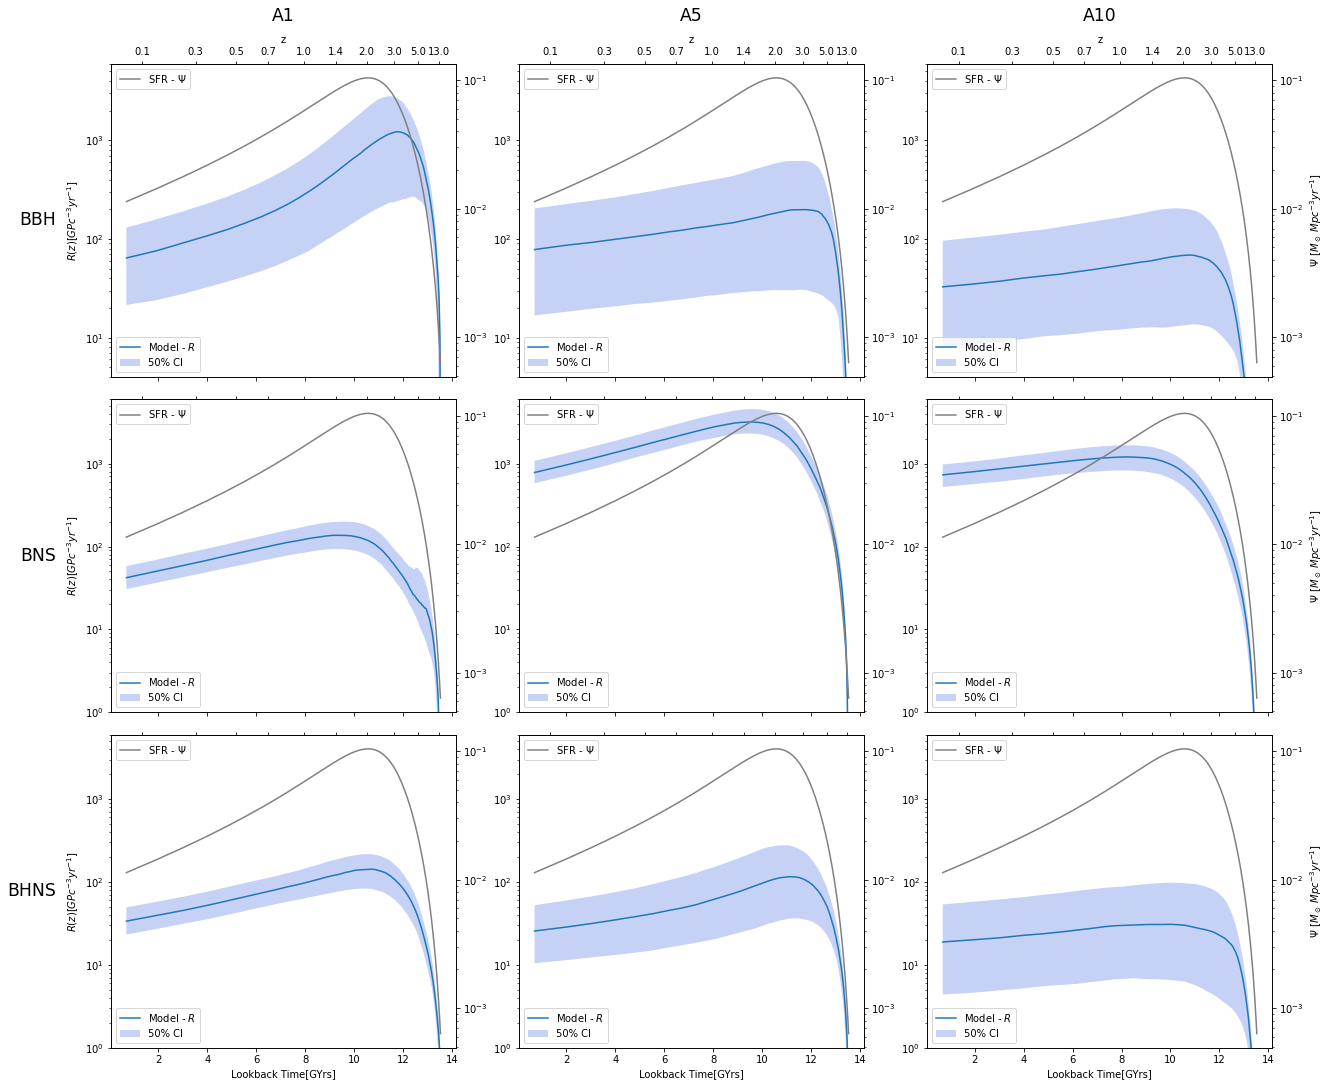

In [4]:
fit_res = grid_plot([data_BBH_A1, data_BBH_A5, data_BBH_A10,
            data_BNS_A1, data_BNS_A5, data_BNS_A10,
            data_BHNS_A1, data_BHNS_A5, data_BHNS_A10,],  y_hi = [6000,6000,6000], y_lo = [4,1,1], fit = False)

### Mass plots

In [9]:
cat_BBH_A1 = load_mass(r'A1/output/BBH/', "BBH*")

cat_BBH_A5 = load_mass(r'A5/output/BBH/', "BBH*")

cat_BBH_A10 = load_mass(r'A10/output/BBH/', "BBH*")


cat_BNS_A1 = load_mass(r'A1/output/BNS/', "BNS*")

cat_BNS_A5 = load_mass(r'A5/output/BNS/', "BNS*")

cat_BNS_A10 = load_mass(r'A10/output/BNS/', "BNS*")


cat_BHNS_A1 = load_mass(r'A1/output/BHNS/', "BHNS*")

cat_BHNS_A5 = load_mass(r'A5/output/BHNS/', "BHNS*")

cat_BHNS_A10 = load_mass(r'A10/output_noin/BHNS/', "BHNS*")

#cat_BBH_A5_det = load_mass(r'A5/output_noin/BBH/', "BBH*")

#cat_BBH_A1_det = load_mass(r'A1/output_noin/BBH/', "BBH*")


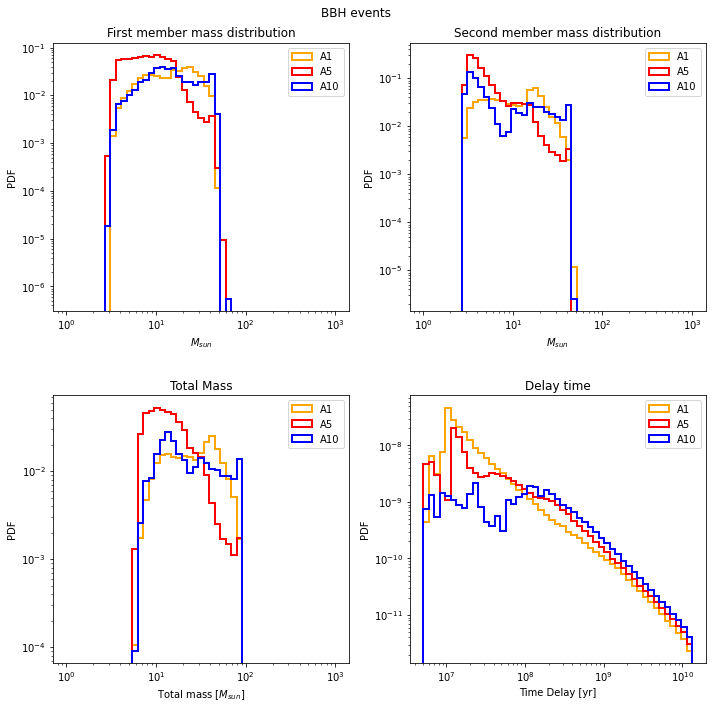

In [6]:
multiplot([cat_BBH_A1, cat_BBH_A5, cat_BBH_A10],title = "BBH events", save = "BBH_mass.pdf")

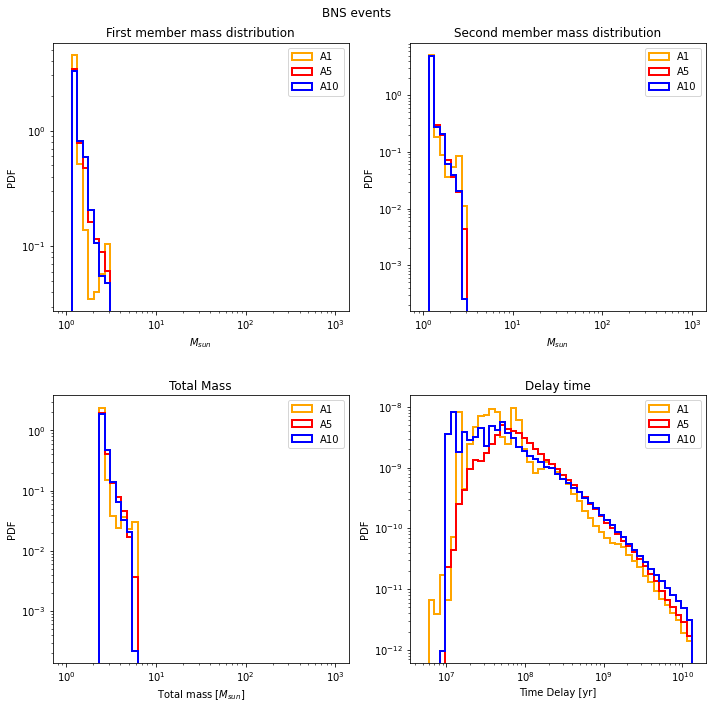

In [7]:
multiplot([cat_BNS_A1, cat_BNS_A5, cat_BNS_A10],title = "BNS events", save = "BNS_mass.pdf")

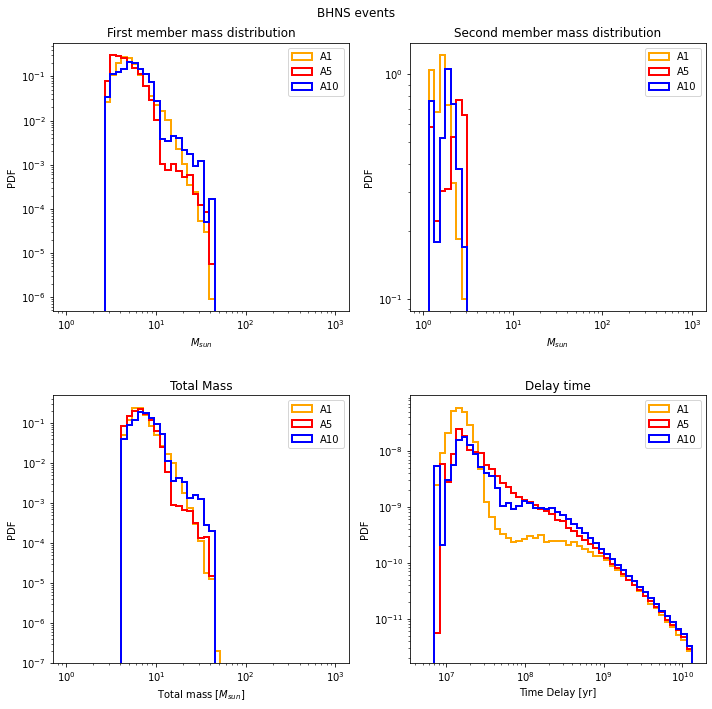

In [8]:
multiplot([cat_BHNS_A1, cat_BHNS_A5, cat_BHNS_A10], title = "BHNS events", save = "BHNS_mass.pdf")

### Mass ordering

In [10]:
vec = cat_BHNS_A1['m1'] == cat_BHNS_A1[['m1', 'm2']].max(axis = 1)
print("The percentage of correctly ordered masses for A1 is",f"{vec.sum()/vec.shape[0]:.2f}")

The percentage of correctly ordered masses for A1 is 0.97


In [11]:
vec = cat_BHNS_A5['m1'] == cat_BHNS_A5[['m1', 'm2']].max(axis = 1)
print("The percentage of correctly ordered masses for A5 is",f"{vec.sum()/vec.shape[0]:.2f}")

The percentage of correctly ordered masses for A5 is 0.35


In [12]:
vec = cat_BHNS_A10['m1'] == cat_BHNS_A10[['m1', 'm2']].max(axis = 1)
print("The percentage of correctly ordered masses for A10 is",f"{vec.sum()/vec.shape[0]:.2f}")

The percentage of correctly ordered masses for A10 is 0.17


### Time delay distributions

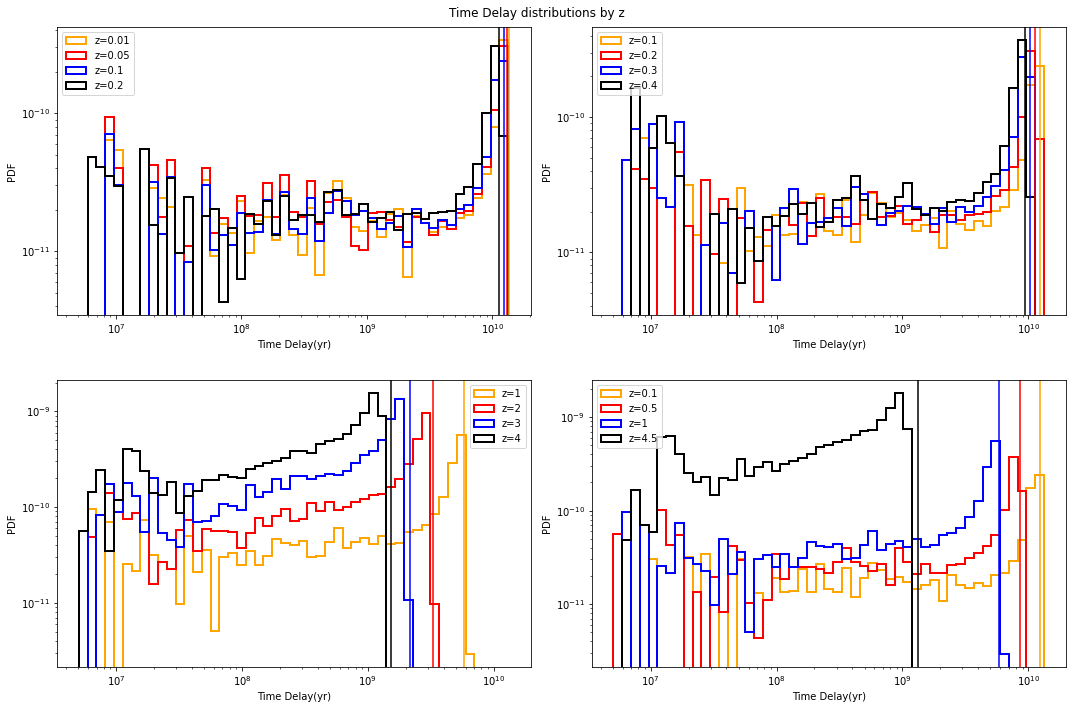

In [12]:
fig, ax = plt.subplots(2,2, figsize =(15,10))
ax = ax.flatten()
t_plot(cat_BBH_A5,[0.01,0.05,0.1,0.2],0.1,ax[0])
t_plot(cat_BBH_A5,[0.1,0.2,0.3,0.4],0.1,ax[1])
t_plot(cat_BBH_A5,[1,2,3,4],0.1,ax[2])
t_plot(cat_BBH_A5,[0.1,0.5,1,4.5],0.1,ax[3])

plt.suptitle("Time Delay distributions by z")
plt.tight_layout(h_pad=3)

### 2D histogram plot

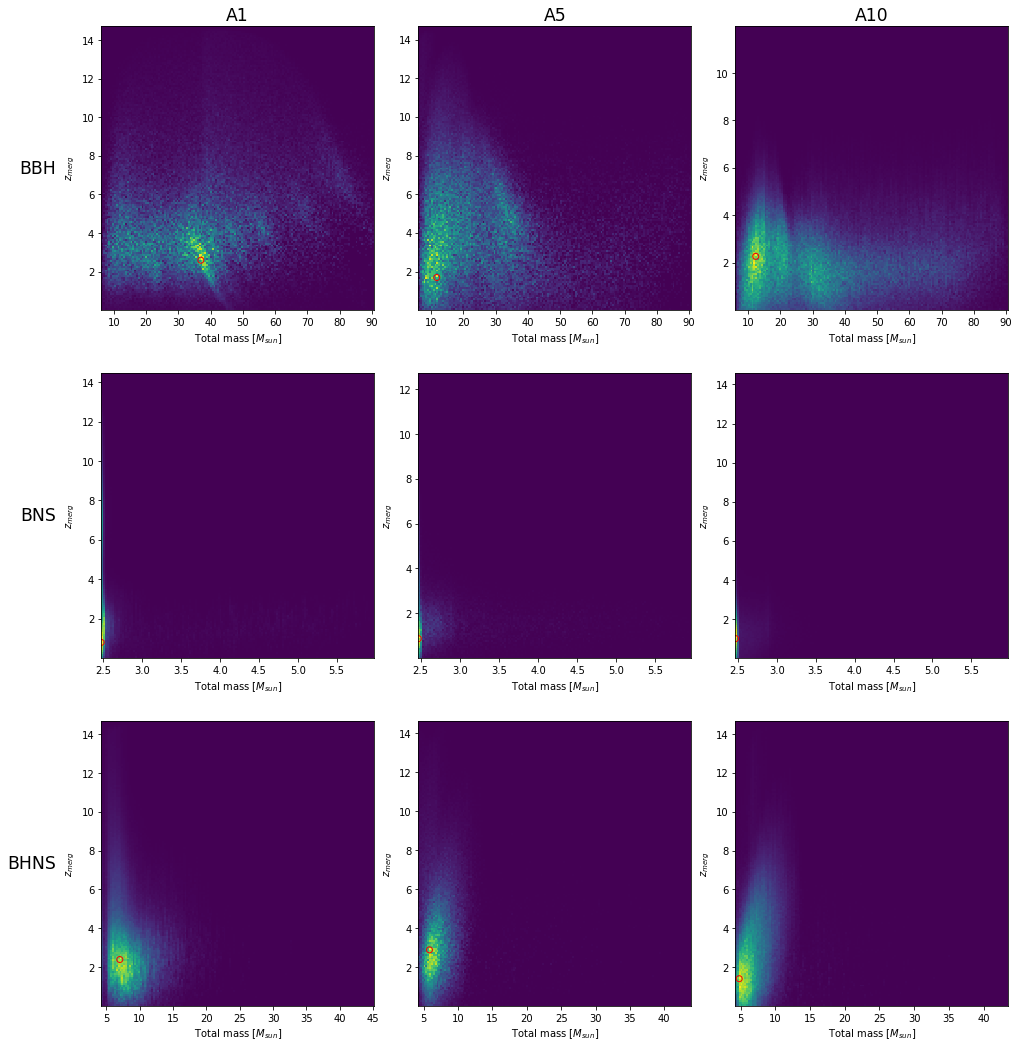

In [9]:
fig, axes = plt.subplots(3,3, figsize = (15,15))

list_cat = [cat_BBH_A1,  cat_BBH_A5,  cat_BBH_A10,  cat_BNS_A1,  cat_BNS_A5,  cat_BNS_A10, cat_BHNS_A1,   cat_BHNS_A5,  cat_BHNS_A10]
list_mrd = [data_BBH_A1, data_BBH_A5, data_BBH_A10, data_BNS_A1, data_BNS_A5, data_BNS_A10, data_BHNS_A1, data_BHNS_A5, data_BHNS_A10]
    
plot_h_2d(list_cat, axes, list_mrd, save = "Hist2D.pdf")

## Week 2

In [8]:
data_BBH_A1 = load_astro("A1/output/BBH/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")
data_BHNS_A1 = load_astro("A1/output/BHNS/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")
data_BNS_A1 = load_astro("A1/output/BNS/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")

data_BBH_A5 = load_astro("A5/output/BBH/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")
data_BHNS_A5 = load_astro("A5/output/BHNS/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")
data_BNS_A5 = load_astro("A5/output/BNS/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")

data_BBH_A10 = load_astro("A10/output/BBH/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")
data_BHNS_A10 = load_astro("A10/output/BHNS/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")
data_BNS_A10 = load_astro("A10/output/BNS/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")

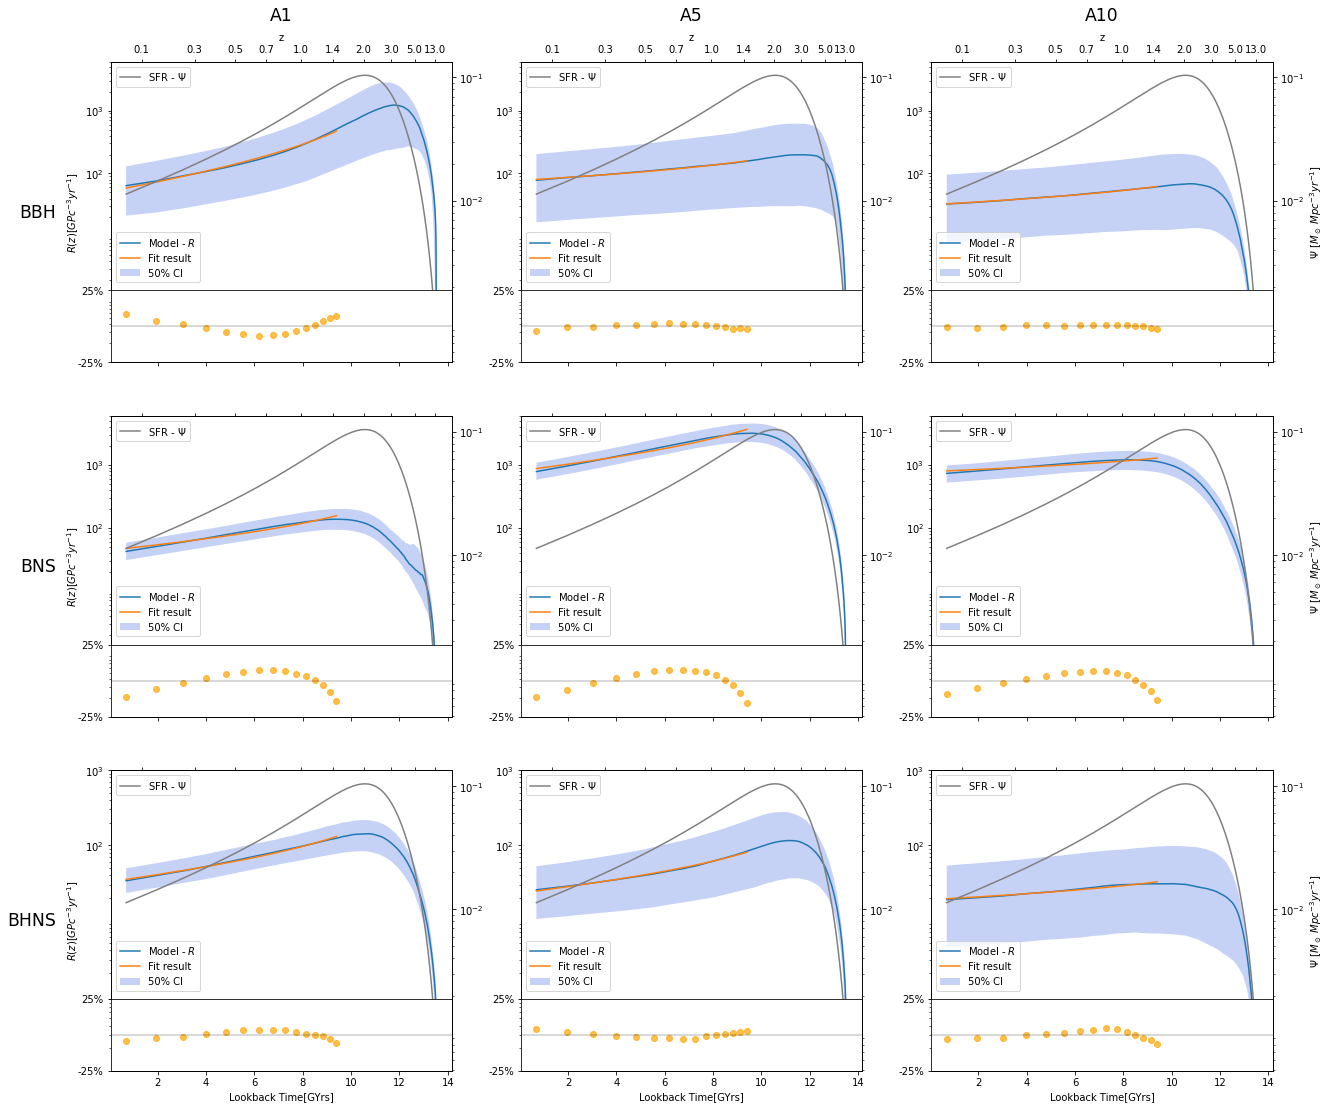

In [38]:
fit_res = grid_plot([data_BBH_A1, data_BBH_A5, data_BBH_A10,
            data_BNS_A1, data_BNS_A5, data_BNS_A10,
            data_BHNS_A1, data_BHNS_A5, data_BHNS_A10,],  y_hi = [6000,6000,500], y_lo = [0.1,0.1,0.1], fit = True, up_to = 1.5)

## Week 3

In [16]:
data_BBH_A1 = load_astro("A1/output/BBH/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")
data_BHNS_A1 = load_astro("A1/output/BHNS/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")
data_BNS_A1 = load_astro("A1/output/BNS/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")

data_BBH_A5 = load_astro("A5/output/BBH/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")
data_BHNS_A5 = load_astro("A5/output/BHNS/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")
data_BNS_A5 = load_astro("A5/output/BNS/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")

data_BBH_A10 = load_astro("A10/output/BBH/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")
data_BHNS_A10 = load_astro("A10/output/BHNS/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")
data_BNS_A10 = load_astro("A10/output/BNS/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")

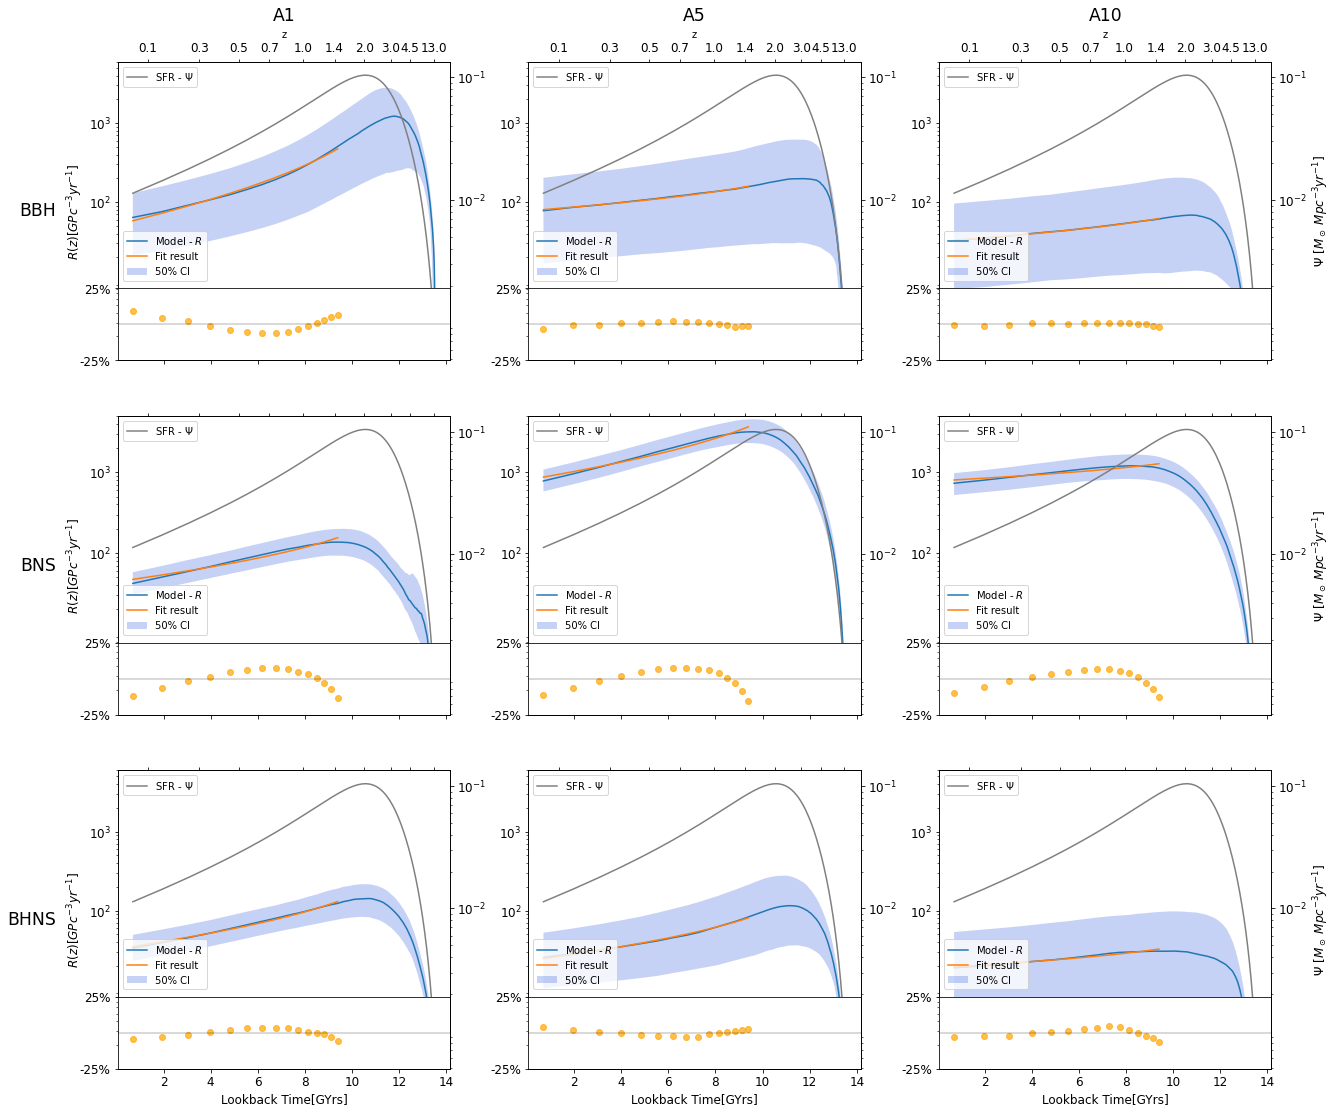

In [40]:
fit_res = grid_plot([data_BBH_A1, data_BBH_A5, data_BBH_A10,
            data_BNS_A1, data_BNS_A5, data_BNS_A10,
            data_BHNS_A1, data_BHNS_A5, data_BHNS_A10,],  y_hi = [6000,5000,6000], y_lo = [1,1,1], fit_err = True, up_to = 1.5, save = "MRD_FIT")

## Week 4

### Metallicity intercept variation

In [3]:
models = ["A1/", "A5/", "A10/"]
cb = ["BBH/", "BNS/", "BHNS/"]
mets = ["/","_01met/","_05met/","_2met/"]
list_all = [[load_astro(glob.glob(mod+f"output"+met+binaries+"MRD*")[0]) for met in mets]  for binaries in cb for mod in models]

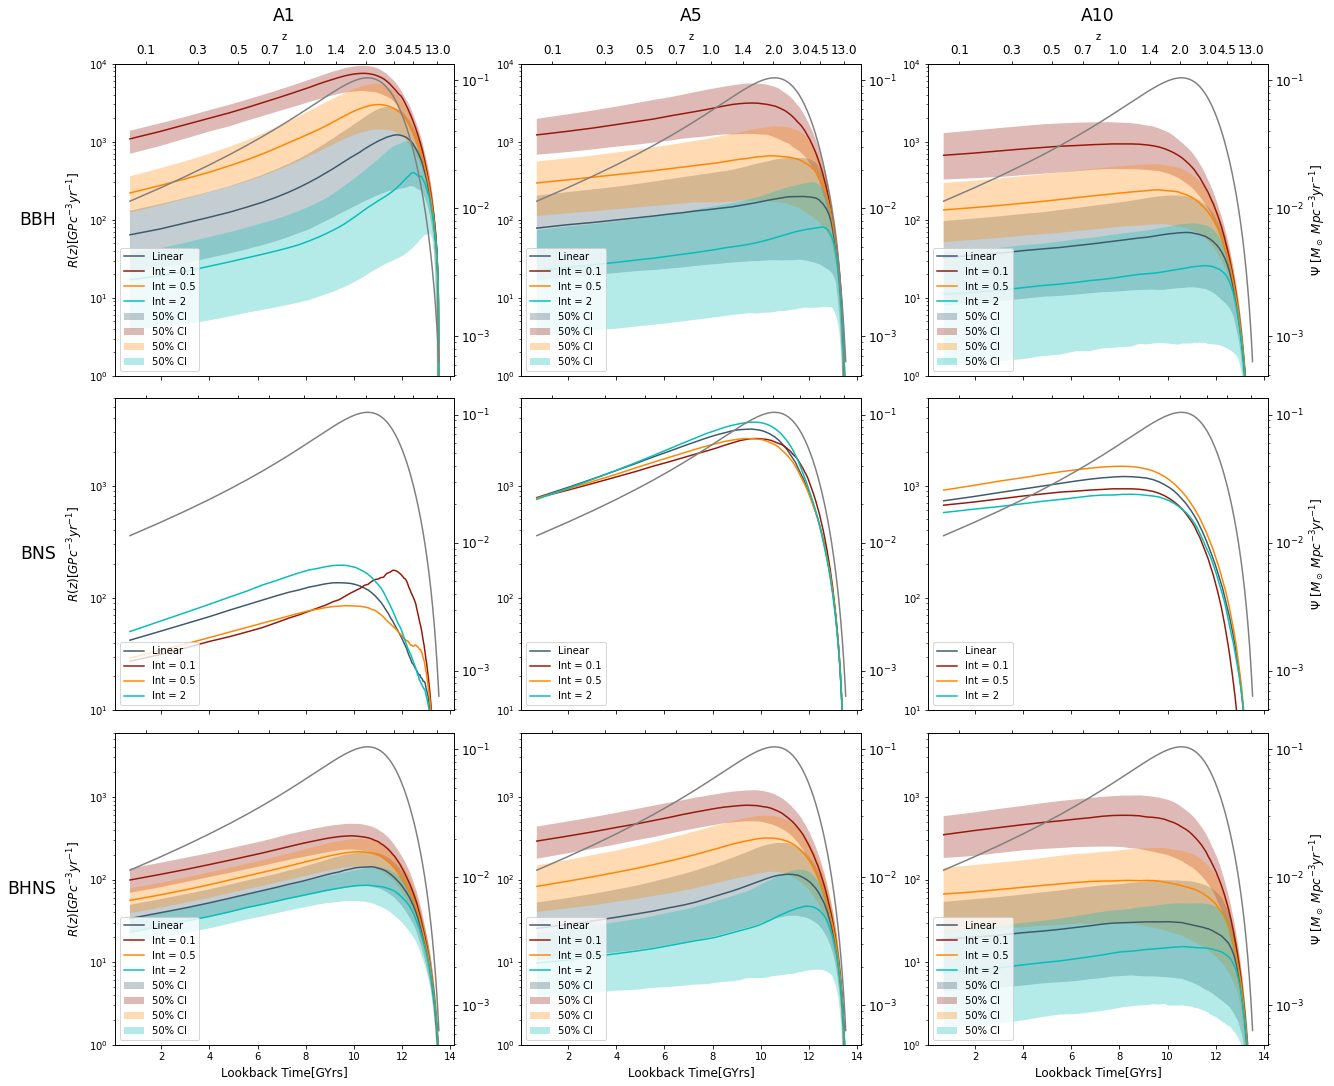

In [4]:
fit_res = multi_grid_plot(list_all,
                             y_hi = [10000,6000,6000], y_lo = [1,10,1], err = [True, False, True], labels = ["Linear","Int = 0.1","Int = 0.5","Int = 2"],save = "INT_MRD.pdf")

### New galaxy model

In [36]:
models = ["A1/", "A5/", "A10/"]
cb = ["BBH/", "BNS/", "BHNS/"]
mets = ["/","_FMR/","_MZR/"]

list_str = [[(glob.glob(mod+f"output"+met+binaries+"MRD*")[0]) for met in mets]  for binaries in cb for mod in models]
list_all = [[load_astro(glob.glob(mod+f"output"+met+binaries+"MRD*")[0]) for met in mets]  for binaries in cb for mod in models]

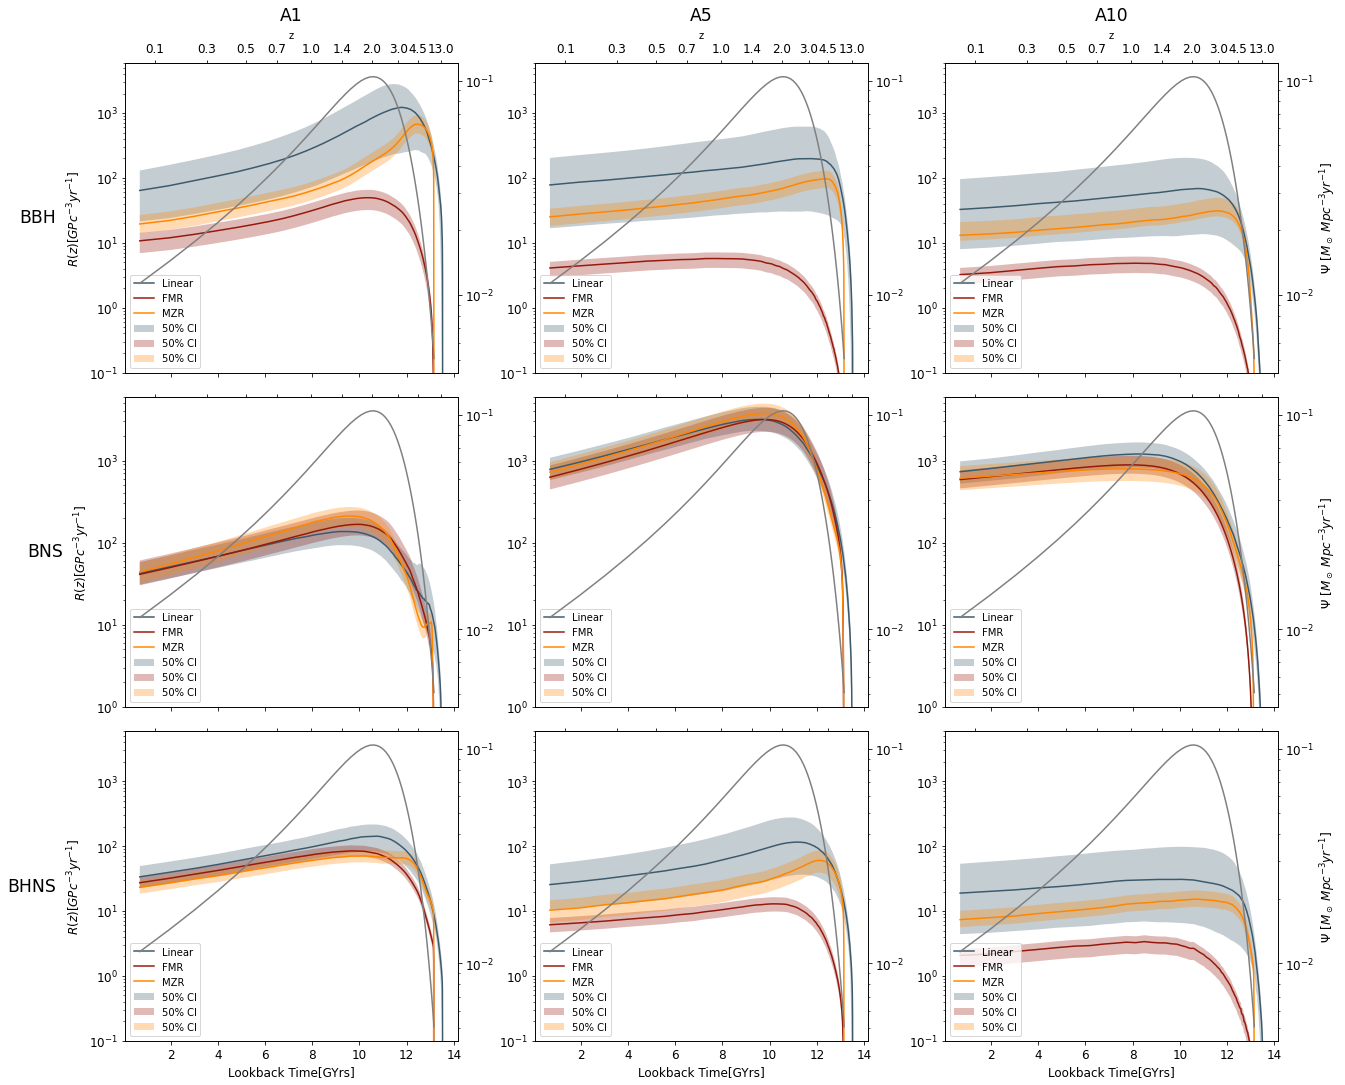

In [42]:
fit_res = multi_grid_plot(list_all,
                             y_hi = [6000,6000,6000], y_lo = [0.1,1,0.1], err = [True, True, True], labels = ["Linear","FMR","MZR"], save = "NGM_MRD.pdf")

## Iteration test

<ipython-input-39-b23873ee677a>:439: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_i["LBtime"] = Planck.lookback_time(df_i.iloc[:,0])


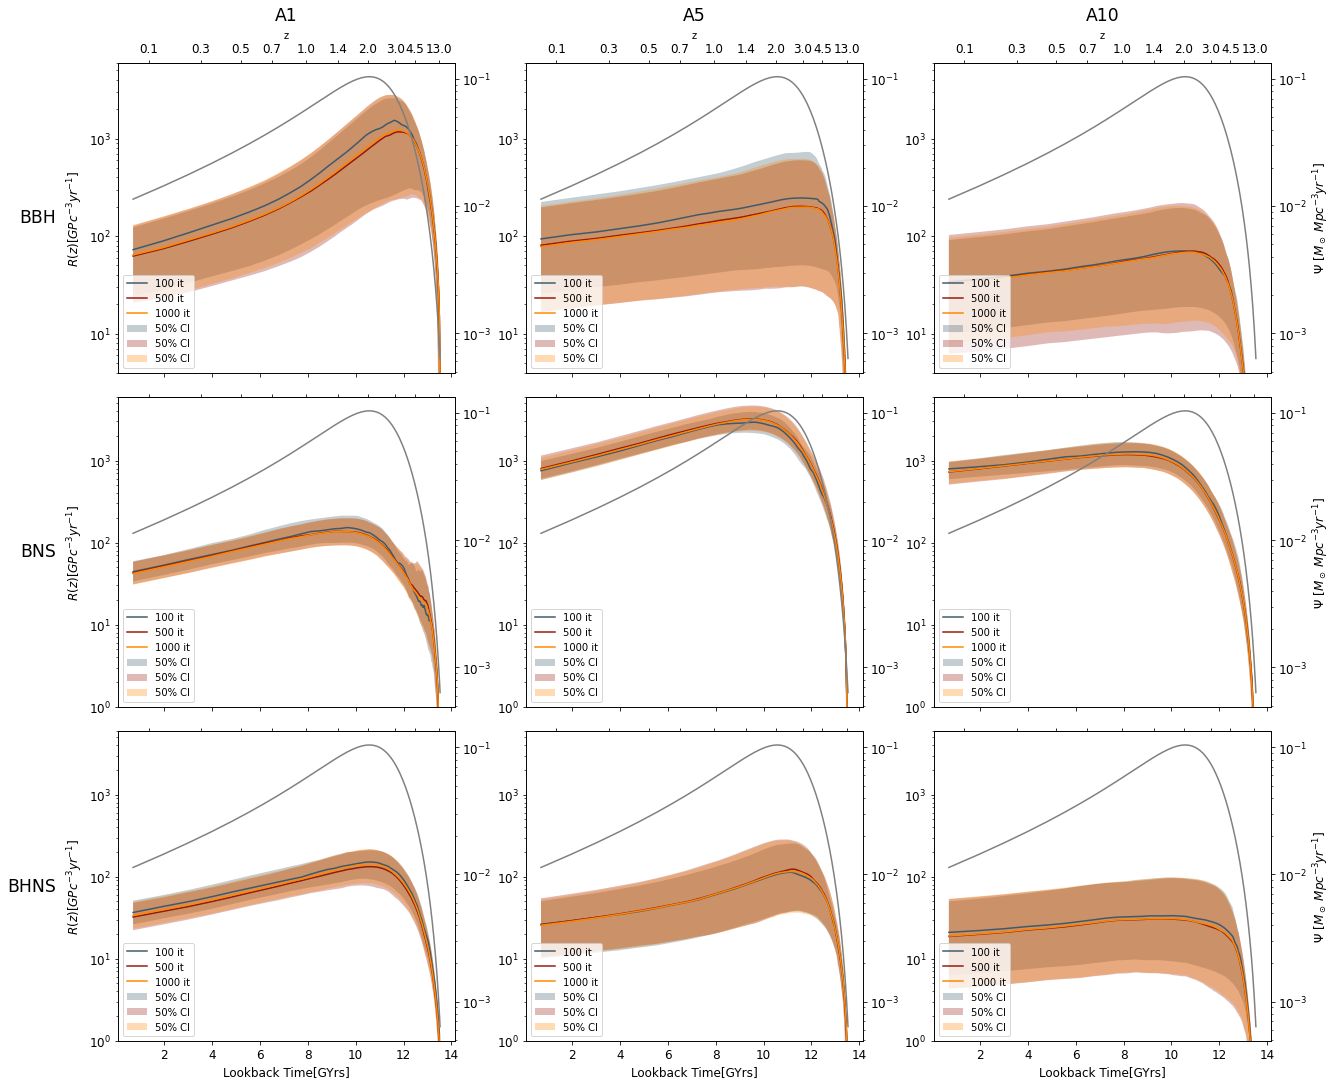

In [41]:
fit_res = multi_grid_plot([[data_BBH_A1.iloc[:,:100], data_BBH_A1.iloc[:,np.concatenate([[True],[False]*100,[True]*500,[False]*(data_BBH_A1.shape[1]-601)])], data_BBH_A1], 
                           [data_BBH_A5.iloc[:,:100], data_BBH_A5.iloc[:,np.concatenate([[True],[False]*100,[True]*500,[False]*(data_BBH_A5.shape[1]-601)])], data_BBH_A5], 
                           [data_BBH_A10.iloc[:,:100], data_BBH_A10.iloc[:,np.concatenate([[True],[False]*100,[True]*500,[False]*(data_BBH_A10.shape[1]-601)])], data_BBH_A10], 
                           [data_BNS_A1.iloc[:,:100], data_BNS_A1.iloc[:,np.concatenate([[True],[False]*100,[True]*500,[False]*(data_BNS_A1.shape[1]-601)])], data_BNS_A1], 
                           [data_BNS_A5.iloc[:,:100], data_BNS_A5.iloc[:,np.concatenate([[True],[False]*100,[True]*500,[False]*(data_BNS_A5.shape[1]-601)])], data_BNS_A5], 
                           [data_BNS_A10.iloc[:,:100], data_BNS_A10.iloc[:,np.concatenate([[True],[False]*100,[True]*500,[False]*(data_BNS_A10.shape[1]-601)])], data_BNS_A10], 
                           [data_BHNS_A1.iloc[:,:100], data_BHNS_A1.iloc[:,np.concatenate([[True],[False]*100,[True]*500,[False]*(data_BHNS_A1.shape[1]-601)])], data_BHNS_A1], 
                           [data_BHNS_A5.iloc[:,:100], data_BHNS_A5.iloc[:,np.concatenate([[True],[False]*100,[True]*500,[False]*(data_BHNS_A5.shape[1]-601)])], data_BHNS_A5], 
                           [data_BHNS_A10.iloc[:,:100], data_BHNS_A10.iloc[:,np.concatenate([[True],[False]*100,[True]*500,[False]*(data_BHNS_A10.shape[1]-601)])], data_BHNS_A10]], 
                          y_hi = [6000,6000,6000], y_lo = [4,1,1], LBT = False, labels = ["100 it","500 it","1000 it"], 
                          err = [True, True, True], save = "MRD_ITERATION.pdf")